### 8-1. Seq2seq 기반 번역기 만들기

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


### 8-2. 데이터 전처리

#### 데이터 준비하기

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [3]:
# URL로부터 데이터를 다운로드 받는다. 
path_to_zip = tf.keras.utils.get_file( 
    fname = 'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract= True)  # 다운로드 받은 데이터의 압축을 해제할 것인지 여부 

# tf.keras.utils.get_file( ) returns 'Path to the downloaded file'

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt" # spa-eng.zip 폴더 안에 'spa.txt'파일과 '_about.txt' 파일이 있기 때문에 다음과 같이 'spa-eng.text'파일의 경로를 설정

2654208/2638744 [==============================] - 0s 0us/step


In [4]:
# 파일명의 맨 앞에 마침표(.)가 있으면 '히든파일' 
# 즉, '숨겨진 파일'을 의미한다. 
path_to_zip

'/aiffel/.keras/datasets/spa-eng.zip'

In [5]:
os.listdir(os.path.dirname(path_to_zip))

['spa-eng.zip', 'spa-eng']

다운로드받은 데이터를 읽어온 후, 형태를 확인해보도록 하죠!

In [6]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [7]:
# 데이터 전처리


def preprocess_sentence(sentence, s_token=False, e_token=False): # Decoder 인풋을 위한 s_token & e_token
    sentence = sentence.lower()
    
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence) # 해당 문자들을 제외하고 공백으로 치환 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # '\1' means '1번째 Group' # 해당 부호 양 옆에 띄어쓰기 추가 
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러 개의 이어진 띄어쓰기를 하나로 줄임
    
    sentence = sentence.strip() # # 맨 앞과 맨 뒤의 Whitespace( 띄어쓰기, 탭, 엔터 ) 제거 

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("실행 완료")

실행 완료


In [8]:
# 테스트 
preprocess_sentence("Wait.	Esperen.", s_token =True)

'<start> wait . esperen .'

In [9]:
enc_corpus = []
dec_corpus = []

# 학습에 사용할 데이터의 개수
num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


In [10]:
enc_corpus[20:40]

['wait .',
 'go on .',
 'go on .',
 'hello !',
 'i ran .',
 'i ran .',
 'i try .',
 'i won !',
 'oh no !',
 'relax .',
 'smile .',
 'attack !',
 'attack !',
 'get up .',
 'go now .',
 'got it !',
 'got it ?',
 'got it ?',
 'he ran .',
 'hop in .']

#### 데이터 전처리: 토큰화


In [11]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '') 
    
    # filters Default 값 사용 시 , '마침표'와 '!'는 단어 Token으로 처리되지 않는다. 
    # '.': 1,
    # '!': 2,
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

###### 참고

Tokenizer() 내의 filters 파라미터 
- filters = '' 적용 시 
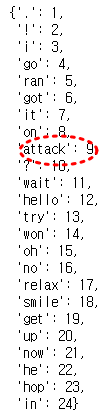

- filters = 'got' 적용 시 
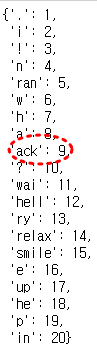

###### 결과  

- 'g' 'o' 't'만으로 구성된 토큰 제거 <br/>
ex) 'got'

- 문자열 내 문자 중 '일부'가 'g' 'o' 't'로 구성된 경우 <br/>
ex) 'get' --> 'e' , 'try' --> 'ry' , 'no' --> 'n' , 'now' --> 'n'&'w' , 'oh'--> 'h'
'won' --> 'w'&'n' 

In [12]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터(80%)와 검증 데이터(20%)로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


### 8-3. 모델 설계


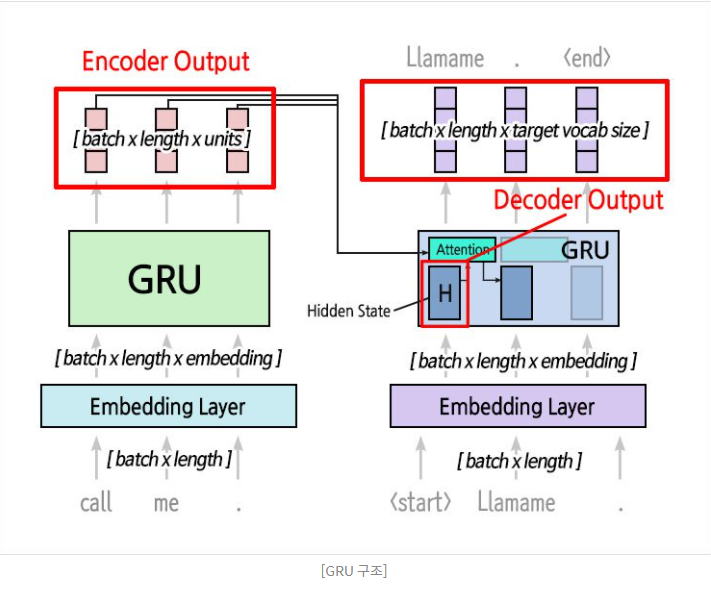

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다.

Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.

여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)  # Encoder의 Hidden State를 입력으로 받아, 종합한 결과를 출력
        h_dec = tf.expand_dims(h_dec, 1) # Decoder의 Hidden State를 입력으로 받아, 종합한 결과를 출력 
        # >>> h_dec shape: [batch x 1 x 이전 Layer의 Dense Layer의 units]
        h_dec = self.w_dec(h_dec) 
        # >>> h_dec shape: [batch x 1 x units]

        score = self.w_com(tf.nn.tanh(h_dec + h_enc)) 
        # >>> score shape: [batch x length x 1]
        
        attn = tf.nn.softmax(score, axis=1) # 확률 계산 
        # >>> attn shape: [batch x length x 1]
        
        context_vec = attn * h_enc # 확률만큼 Encoder의 Hidden State를 반영 
        # >>> h_enc shape:[batch x length x units]
        context_vec = tf.reduce_sum(context_vec, axis=1) # reduce_sum의 해당 axis 내 요소의 개수가 1개뿐이면, 값에는 변화가 없고, shape만 줄어든다. 
        # >>> context_vec shape:[batch x units]
        return context_vec, attn

print("실행 완료")

실행 완료


###### shape 확인

In [14]:
# 상수, 시퀀스, 그리고 난수
# https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/api_docs/python/constant_op.html

tensor_temp = tf.linspace(1,10,10)
tensor_temp = tf.constant(tensor_temp)
tensor_temp

<tf.Tensor: shape=(10,), dtype=float64, numpy=array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])>

In [15]:
tensor_temp = tf.reshape(tensor_temp, [2,-1])
print(tensor_temp.shape)
tensor_temp

(2, 5)


<tf.Tensor: shape=(2, 5), dtype=float64, numpy=
array([[ 1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10.]])>

In [16]:
tensor_temp2 = tf.expand_dims(tensor_temp,1)
tensor_temp2

<tf.Tensor: shape=(2, 1, 5), dtype=float64, numpy=
array([[[ 1.,  2.,  3.,  4.,  5.]],

       [[ 6.,  7.,  8.,  9., 10.]]])>

In [17]:
dense_temp = tf.keras.layers.Dense(3)
dense_temp(tensor_temp2) # 2 x 1 x 3

<tf.Tensor: shape=(2, 1, 3), dtype=float32, numpy=
array([[[-2.0369787,  3.7656782,  0.9648902]],

       [[-5.648451 ,  9.531496 ,  3.6442108]]], dtype=float32)>

In [18]:
tf.reduce_sum(dense_temp(tensor_temp2),axis=1) # 2 x 3

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.0369787,  3.7656782,  0.9648902],
       [-5.648451 ,  9.531496 ,  3.6442108]], dtype=float32)>

In [19]:
tensor_temp = tf.linspace(1,60,60)
tensor_temp = tf.constant(tensor_temp)
tensor_temp = tf.reshape(tensor_temp, [5,6,2])
tensor_temp

<tf.Tensor: shape=(5, 6, 2), dtype=float64, numpy=
array([[[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [11., 12.]],

       [[13., 14.],
        [15., 16.],
        [17., 18.],
        [19., 20.],
        [21., 22.],
        [23., 24.]],

       [[25., 26.],
        [27., 28.],
        [29., 30.],
        [31., 32.],
        [33., 34.],
        [35., 36.]],

       [[37., 38.],
        [39., 40.],
        [41., 42.],
        [43., 44.],
        [45., 46.],
        [47., 48.]],

       [[49., 50.],
        [51., 52.],
        [53., 54.],
        [55., 56.],
        [57., 58.],
        [59., 60.]]])>

In [20]:
tensor_temp = tf.linspace(1,60,60)
tensor_temp = tf.constant(tensor_temp)
tensor_temp = tf.reshape(tensor_temp, [5,6,2])
tensor_temp = tf.reshape(tensor_temp, [-1,2])
tensor_temp

<tf.Tensor: shape=(30, 2), dtype=float64, numpy=
array([[ 1.,  2.],
       [ 3.,  4.],
       [ 5.,  6.],
       [ 7.,  8.],
       [ 9., 10.],
       [11., 12.],
       [13., 14.],
       [15., 16.],
       [17., 18.],
       [19., 20.],
       [21., 22.],
       [23., 24.],
       [25., 26.],
       [27., 28.],
       [29., 30.],
       [31., 32.],
       [33., 34.],
       [35., 36.],
       [37., 38.],
       [39., 40.],
       [41., 42.],
       [43., 44.],
       [45., 46.],
       [47., 48.],
       [49., 50.],
       [51., 52.],
       [53., 54.],
       [55., 56.],
       [57., 58.],
       [59., 60.]])>

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        # If you subclass Model, you can optionally have a training argument (boolean) in call(), 
        # which you can use to specify a different behavior in training and inference:
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        # >>> out shape : [ batch x time_steps x enc_units ]
        return out

In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        # >>> 마지막 차원 : self.dec_units + embedding_dim
        
        out, h_dec = self.gru(out)
        # >>> out : [batch x time_steps x dec_units]
        # >>> h_dec : 마지막 time_step의 Hidden_state
        
        out = tf.reshape(out, (-1, out.shape[2])) # out.shape[2] : dec_units
        # >>> out shape = [ {batch x time_steps}  x dec_units ]
        out = self.fc(out)
        # >>> out shape = [ {batch x time_steps}  x vocab_size ]

        return out, h_dec, attn

In [23]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


### 8-4. Model Training (1) Optimizer & Loss

#### Optimizer & Loss

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # from_logits는 확률분포가 Softmax 함수를 거쳐서 들어오는지 여부와 관련 

# >>> SparseCategoricalCrossentropy : 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교하여 
# CrossEntropy값을 구한다. 

# CategoricalCrossentropy VS SparseCategoricalCrossentropy
# 1) CategoricalCrossentropy --> [0.1 , 0.2 , 0.6] 과 [0,0,1]을 비교한다. 
# 2) SparseCategoricalCrossentropy --> [0.1 , 0.2 , 0.6] 과 (인덱스 답안) '2'를  비교한다. 

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 0인 경우,False, 0이 아닌 경우, True 
    loss = loss_object(real, pred) 
    
    mask = tf.cast(mask, dtype=loss.dtype) # mask는 <pad> 토큰에 해당하는 부분의 Loss를 구하지 않도록 해준다. 
    loss *= mask 
    
    return tf.reduce_mean(loss) # axis가 따로 설정 안되어있다면, None이고, 이는 모든 차원을 축소시킨다. 
                                 # tf.reduce_mean을 사용할때는 dtype을 유의하도록 하자 
print("실행 완료")

실행 완료


### 8-5. Model Training (2) train_step 구현하기

In [25]:
@tf.function # GPU로 텐서플로우 연산 가속화
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]  # t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의
    loss = 0

    with tf.GradientTape() as tape: 
        enc_out = encoder(src) # 컨텍스트 벡터인 enc_out 을 생성
        h_dec = enc_out[:, -1]
        
        # Decoder에 입력으로 전달할 <start> 토큰 문장 생성
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) 

        for t in range(1, tgt.shape[1]):
            # start 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out) 
            
            loss += loss_function(tgt[:, t], pred) # 예측된 단어와 정답 간의 Loss를 구함
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### 8-6. Model Training (3) Training 시작

In [26]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    # 미니배치 학습 
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [00:43<00:00,  8.53it/s, Loss 0.1412]


In [27]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:04<00:00, 22.52it/s, Test Loss 0.7501]


Input: can i have some coffee ?
Predicted translation: me pueden dar algo de comer ? <end> 


/tmp/ipykernel_15/2734301489.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_15/2734301489.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


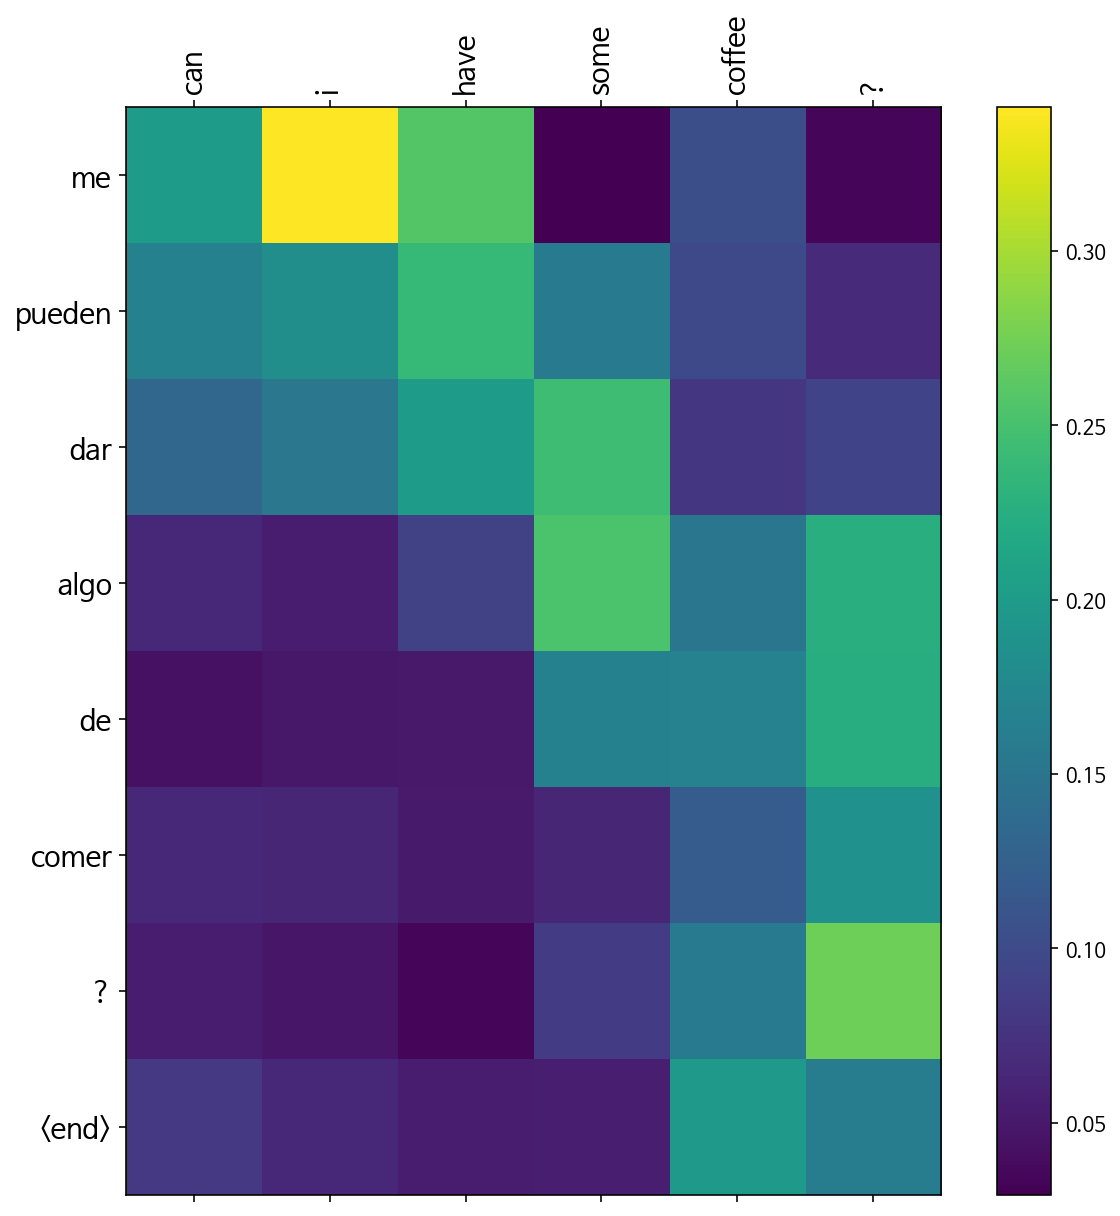

In [31]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)  # axes.SubplotBase  or  Axes
    cax = ax.matshow(attention, cmap='viridis')  # AxesImage
    
    fig.colorbar(cax) # color bar 추가 # Axes 인스턴스를 입력으로 받는다. 
    
    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    
    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

###### 참고

- 'me' : '나'
- 'pueden' : 할 수 있다. 
-  'dar' : 공급하다, 주다
- 'algo' : 어떤 것, 무엇인가, 무엇이라도 
- 'de' : ~의
- 'comer' : 먹거리, 음식, 먹어 치우다